In [1]:
%config Completer.use_jedi = False

In [2]:
cd models

/Users/cmougan/Desktop/Novartis2021/models


In [3]:
# %% Imports
import pandas as pd
import sys
import numpy as np
import shap

sys.path.append("../")
from metrics.metric_participants import ComputeMetrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklego.preprocessing import ColumnSelector
from sklearn.linear_model import LinearRegression
from sktools import IsEmptyExtractor
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
import random
from doubt import Boot
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


from eda.checker import check_train_test

random.seed(0)

sales_train = pd.read_csv("../data/data_raw/sales_train.csv")
df_full = pd.read_csv("../data/split.csv")
df_region = pd.read_csv("../data/data_raw/regions.csv")
regions_hcps = pd.read_csv("../data/data_raw/regions_hcps.csv")
activity_features = pd.read_csv("../data/features/activity_features.csv")
brands_3_12 = pd.read_csv("../data/features/brand_3_12_market_features_lagged.csv")
rte_basic = pd.read_csv("../data/features/rte_basic_features.csv").drop(
    columns=["sales", "validation"]
)

market_size = pd.read_csv("../data/market_size.csv")

# For reproducibility
random.seed(0)
VAL_SIZE = 38
SUBMISSION_NAME = "empty_extractor_target_encoder"
RETRAIN = True

# %% Training weights
market_size = (
    market_size
    .assign(weight=lambda x: 100 / x['sales'])
    .rename(columns={"sales": 'market_size'})
)

market_size

# %% Add region data
df_feats = df_full.merge(df_region, on="region", how="left")
df_feats = pd.merge(left=df_feats, right=regions_hcps, how="left", on="region")
df_feats = df_feats.merge(
    activity_features, on=["month", "region", "brand"], how="left"
)
df_feats = df_feats.merge(rte_basic, on=["month", "region", "brand"], how="left")
df_feats = df_feats.merge(brands_3_12, on=["month", "region"], how="left")
df_feats["whichBrand"] = np.where(df_feats.brand == "brand_1", 1, 0)

df_feats = df_feats.merge(market_size, on='region', how="left")

df_feats['month_brand'] = df_feats.month + '_' + df_feats.brand

# drop sum variables
cols_to_drop = ["region", "sales", "validation", "market_size", "weight"]

# %% Split train val test
X_train = df_feats.query("validation == 0").drop(columns=cols_to_drop)
y_train = df_feats.query("validation == 0").sales
weights_train = df_feats.query("validation == 0").weight

X_val = df_feats.query("validation == 1").drop(columns=cols_to_drop)
y_val = df_feats.query("validation == 1").sales

X_full = df_feats.query("validation.notnull()", engine="python").drop(
    columns=cols_to_drop
)
y_full = df_feats.query("validation.notnull()", engine="python").sales
weights_full = df_feats.query("validation.notnull()", engine="python").weight

X_test = df_feats.query("validation.isnull()", engine="python").drop(
    columns=cols_to_drop
)
y_test = df_feats.query("validation.isnull()", engine="python").sales

check_train_test(X_train, X_val)
check_train_test(X_train, X_test, threshold=0.3)
check_train_test(X_val, X_test)


In [20]:

# %%
select_cols = [
    "month_brand",
    "sales_brand_3",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_12_market_per_region",
    "sales_brand_12_market",
    'no. openings_Pediatrician',
    'tier_openings_Internal medicine / pneumology',
    'area_x'
    
]

assert len([col for col in X_train.columns if col in select_cols]) == len(select_cols)

# %%
lgbms = {}
pipes = {}
train_preds = {}
val_preds = {}
test_preds = {}

model = Boot(CatBoostRegressor(verbose=0,iterations=150))

pipe = Pipeline(
        [   
            ("te", TargetEncoder(cols=["month_brand", "month", "brand"])),
            ("selector", ColumnSelector(columns=select_cols)),
            ("empty", IsEmptyExtractor()),
            ("imputer", SimpleImputer(strategy="median")), 
            ("lgb", model)
        ]
    )



In [21]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['month_brand', 'month', 'brand'])),
                ('selector',
                 ColumnSelector(columns=['month_brand', 'sales_brand_3',
                                         'inverse_tier_f2f',
                                         'hcp_distinct_Internal medicine / '
                                         'pneumology',
                                         'sales_brand_12_market_per_region',
                                         'sales_brand_12_market',
                                         'no. openings_Pediatrician',
                                         'tier_openings_Internal medicine / '
                                         'pneumology',
                                         'area_x'])),
                ('empty', IsEmptyExtractor()),
                ('imputer', SimpleImputer(strategy='median')),
                ('lgb', Boot(model=CatBoostRegressor, random_seed=None))])

In [22]:
train_preds,interval_train= pipe.predict(X_train,uncertainty=0.1)
val_preds,interval_val = pipe.predict(X_val,uncertainty=0.1)


In [23]:
#Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds)
    .assign(lower=interval_train[:,0])
    .assign(upper=interval_train[:,1]))



In [24]:
ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

print(ComputeMetrics(train_preds_df, sales_train, ground_truth_train))


(16.39300487202692, 111.68344624980375)


In [26]:
# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds)
    .assign(lower=interval_val[:,0])
    .assign(upper=interval_val[:,1]))


ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]
print(ComputeMetrics(val_preds_df, sales_train, ground_truth_val))

(40.258934208364316, 176.097165944732)


In [27]:
pipe.fit(X_full, y_full)

Pipeline(steps=[('te', TargetEncoder(cols=['month_brand', 'month', 'brand'])),
                ('selector',
                 ColumnSelector(columns=['month_brand', 'sales_brand_3',
                                         'inverse_tier_f2f',
                                         'hcp_distinct_Internal medicine / '
                                         'pneumology',
                                         'sales_brand_12_market_per_region',
                                         'sales_brand_12_market',
                                         'no. openings_Pediatrician',
                                         'tier_openings_Internal medicine / '
                                         'pneumology',
                                         'area_x'])),
                ('empty', IsEmptyExtractor()),
                ('imputer', SimpleImputer(strategy='median')),
                ('lgb', Boot(model=CatBoostRegressor, random_seed=None))])

In [28]:
test_preds,interval_test = pipe.predict(X_test,uncertainty=0.1)

In [31]:
# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds)
    .assign(lower=interval_test[:,0])
    .assign(upper=interval_test[:,0])
)

In [33]:
test_preds_df.to_csv(f"../submissions/bootCat.csv", index=False)

In [ ]:
if RETRAIN:
    pipe.fit(X_train, y_train)
    pipes[quantile].fit(X_full, y_full)
        # , lgb__sample_weight=weights_full)
    test_preds[quantile] = pipes[quantile].predict(X_test)


# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds[0.5].clip(0))
    .assign(lower=test_preds[0.1].clip(0))
    .assign(upper=test_preds[0.9].clip(0))
)

test_preds_df.to_csv(f"../submissions/{SUBMISSION_NAME}.csv", index=False)


# %%

# %%
pd.Series(test_preds[0.1].clip(0)).describe()
# %%


In [26]:
X_train.shape

(3164, 180)

In [7]:
X_val.shape

(1064, 180)

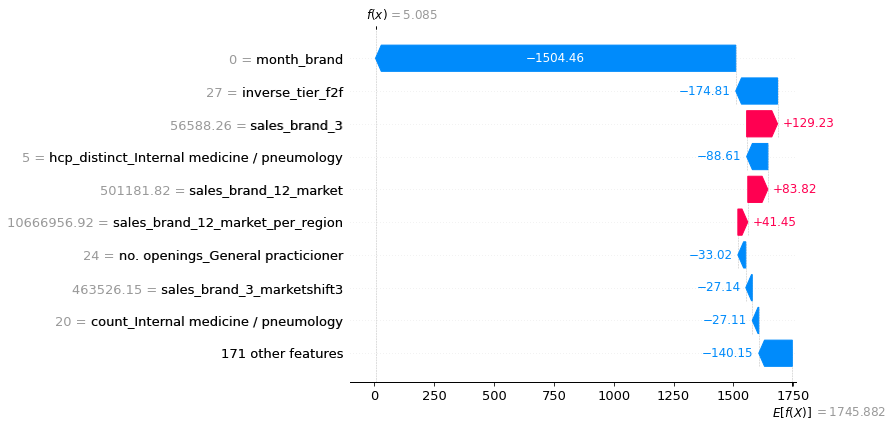

In [12]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(pipes[0.5].named_steps["lgb"])
shap_values = explainer(
    pd.DataFrame(pipes[0.5][:-1].transform(X_train), columns=X_train.columns)
)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

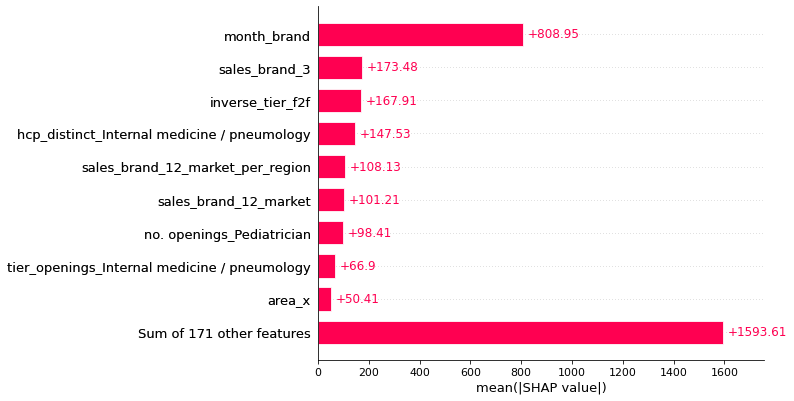

In [17]:
shap.plots.bar(shap_values)

In [ ]:
X_train['tier_openings_Internal medicine / pneumology',]

In [22]:
X_train.columns

Index(['count', 'count_other', 'inverse_tier_other', 'count_Pediatrician',
       'count_video', 'Pediatrician', 'area_x',
       'count_Internal medicine / pneumology_3m',
       'inverse_tier_Internal medicine / pneumology_3m'],
      dtype='object')

In [40]:
# %% Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds[0.5])
    .assign(lower=train_preds[0.1].clip(0))
    .assign(upper=train_preds[0.9])
)

ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

print(ComputeMetrics(train_preds_df, sales_train, ground_truth_train))

# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds[0.5])
    .assign(lower=val_preds[0.1].clip(0))
    .assign(upper=val_preds[0.9])
)

ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]

print(ComputeMetrics(val_preds_df, sales_train, ground_truth_val))

# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds[0.5])
    .assign(lower=test_preds[0.1].clip(0))
    .assign(upper=test_preds[0.9])
)

test_preds_df.to_csv(f"../submissions/{SUBMISSION_NAME}.csv", index=False)


# %%

# %%

(33.31066999327685, 98.58349196977866)
(66.63760605499311, 218.85801154595615)
